# Detecting anomalous reviews

## Load the dataset and NLP libraries

In [51]:
import pandas as pd
import spacy
from matplotlib import pyplot as plt

nlp = spacy.load('en_core_web_sm')

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

Check amount of reviews per each class.

In [4]:
df.groupby('sentiment').count()

,review
sentiment,
negative,2502
positive,25000


## Create numerical features based on the review content

For each row, the parse the review using SpaCy and attribute a number of numberical features as follows.

In [37]:
n_chars = [] # number of all characters
n_words = [] # number of words
n_punct = [] # number of punctuation characters
n_digit = [] # number of digits/numbers
n_stopw = [] # number of stop words
n_sents = [] # number of sentences
n_unique_words = [] # number of unique words
n_unique_chars = [] # number of unique characters

for i,row in df.iterrows():
    txt = row['review']
    doc = nlp(txt)
    
    n_chars.append(len(txt))
    n_words.append(len(doc))
    n_punct.append(len([t for t in doc if t.is_punct]))
    n_digit.append(sum(c.isdigit() for c in txt))
    n_stopw.append(len([t for t in doc if t.is_stop]))
    n_sents.append(len(list(doc.sents)))
    n_unique_words.append(len(set([t.lemma_.lower() for t in doc if t.is_alpha])))
    n_unique_chars.append(len(set(txt)))

...and include them in the original dataframe.

In [78]:
df['n_chars'] = n_chars
df['n_words'] = n_words
df['n_punct'] = n_punct
df['n_digit'] = n_digit
df['n_stopw'] = n_stopw
df['n_sents'] = n_sents
df['n_unique_words'] = n_unique_words
df['n_unique_chars'] = n_unique_chars

## Normalize some features by the number of words

We need to normalize certain columns, because these absolute numbers can't compared with each other.

In [79]:
for c in ['n_chars',
          'n_punct',
          'n_digit',
          'n_stopw']:
    df[c] = df[c]/(df['n_words']+1)

In [80]:
df.head(3)

,review,sentiment,n_chars,n_words,n_punct,n_digit,n_stopw,n_sents,n_unique_words,n_unique_chars,anomaly_score
0,An excellent cast who do their best with an aw...,negative,4.953704,107,0.083333,0.0,0.518519,5,70,33,1
1,A dreary and pointless bit of fluff (bloody fl...,negative,4.908257,108,0.155963,0.0,0.431193,6,64,36,1
2,If the writer/director is reading this (and I ...,negative,4.603448,115,0.094828,0.0,0.500000,7,61,45,1


## Quick look at the ditributions

Now we can have a look whether the features we prepared show any difference between the two classes. This will be helpful in the classification task. 

In [177]:
df.groupby('sentiment').mean() # !!!

,n_chars,n_words,n_punct,n_digit,n_stopw,n_sents,n_unique_words,n_unique_chars,anomaly_score,decision_function
sentiment,,,,,,,,,,
negative,4.625055,78.383293,0.124819,0.014361,0.477796,4.815747,48.260991,36.091527,0.943245,0.074518
positive,4.835612,270.596320,0.114689,0.012292,0.476969,11.559520,126.551880,47.143800,0.983600,0.092339


Let's now look at some of the distributions

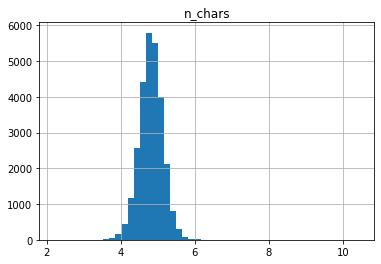

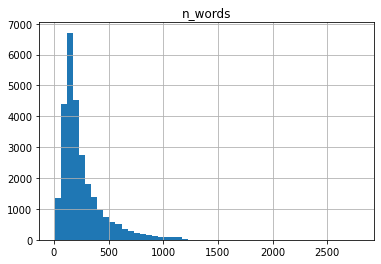

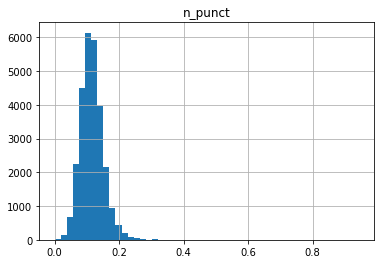

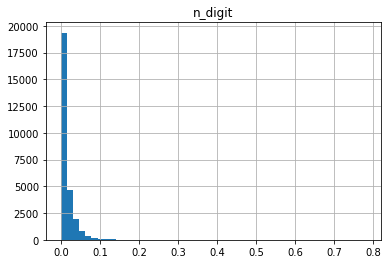

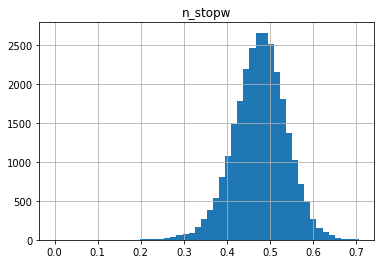

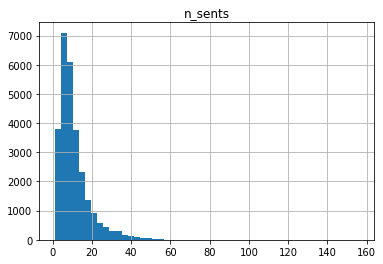

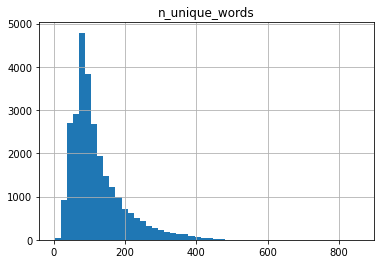

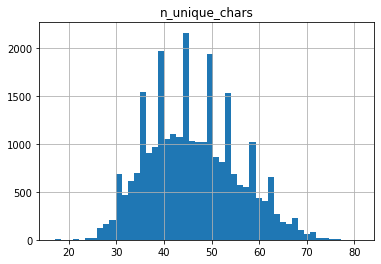

In [81]:
feature_names = [c for c in df.columns if c.startswith('n_')]
for f in feature_names:
    plt.figure()
    plt.title(f)
    df[f].hist(bins=50)

## Detect outliers with Isolation Forest

Now that we have our features ready, we can use Isolation Forest to detect the outliers. We use an arbitrarily set contamination level to 1%.

In [55]:
from sklearn.ensemble import IsolationForest

In [58]:
X = df[feature_names]

In [132]:
clf = IsolationForest(n_estimators=100, contamination=0.01, max_features=1, random_state=7)

In [133]:
df['anomaly_score'] = clf.fit_predict(X)

/home/dev/venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/dev/venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
df['decision_function']=clf.decision_function(X)

We ended up with 1% of outlying results, as expected.

In [135]:
df.groupby('anomaly_score').count()['review']

anomaly_score
-1      276
 1    27226
Name: review, dtype: int64

Let's have a look at the most outlying examples...

In [137]:
df[df['anomaly_score']==-1].sort_values('decision_function').head(3)

,review,sentiment,n_chars,n_words,n_punct,n_digit,n_stopw,n_sents,n_unique_words,n_unique_chars,anomaly_score,decision_function
27223,mature intelligent and highly charged melodram...,positive,5.682927,40,0.024390,0.097561,0.439024,2,31,30,-1,-0.104372
15785,"As so many others have written, this is a wond...",positive,3.886076,236,0.324895,0.780591,0.122363,7,74,57,-1,-0.102542
11021,I will divide my review into following 5 categ...,positive,3.567493,362,0.440771,0.055096,0.247934,16,103,62,-1,-0.098562


Double check at the decision function and its range.

<AxesSubplot:>

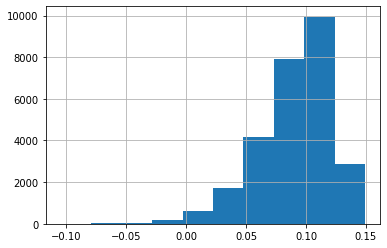

In [138]:
df['decision_function'].hist()

## Overall feature contributions | hack with RFC

To get the feature contribution, we train a balanced Random Forest Classifier using the labels created in the process above.

In [139]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [142]:
clf2 = RFC(n_estimators=100, class_weight='balanced')

In [143]:
clf2.fit(X, df['anomaly_score'])

RandomForestClassifier(class_weight='balanced')

The feature importance is listed below. As we can see, the number of words and unique characters are the features the most often identifying an outlier.

<BarContainer object of 8 artists>

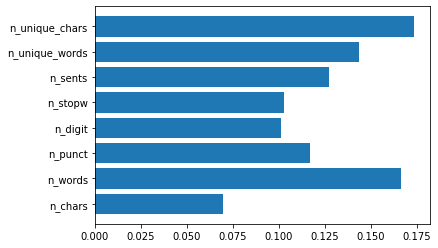

In [146]:
idx = 
plt.barh(feature_names, clf2.feature_importances_, )
    

## Feature importance of specific examples (approximation)

Now, just for fun, we can have a look at some specific examples of outliers and check their features.

In [165]:
from scipy.stats import percentileofscore
import numpy as np

In [148]:
sample = df[df['anomaly_score']==-1].sort_values('decision_function').sample(10)
sample

,review,sentiment,n_chars,n_words,n_punct,n_digit,n_stopw,n_sents,n_unique_words,n_unique_chars,anomaly_score,decision_function
2764,WWE was in need of a saviour as Wrestlemania 1...,positive,5.304348,988,0.062690,0.008089,0.448938,38,354,62,-1,-0.009914
26938,this took me back to my childhood in the 1950 ...,positive,4.508475,58,0.050847,0.067797,0.457627,2,40,51,-1,-0.009906
3195,Set in a California detention camp in an indis...,positive,5.570861,754,0.052980,0.002649,0.512583,20,311,50,-1,-0.001152
2495,"More suspenseful, more subtle, much, much more...",negative,4.692308,12,0.307692,0.000000,0.384615,1,5,21,-1,-0.003740
2420,...an incomprehensible script (when it shouldn...,negative,5.428571,34,0.200000,0.000000,0.342857,1,20,33,-1,-0.024647
2577,"Tony Hawk's Pro Skater 2x, isn't much differen...",positive,4.542702,1287,0.115683,0.073758,0.450311,51,251,64,-1,-0.035534
2700,The 1973 musical version of LOST HORIZON is th...,positive,5.075560,1071,0.084888,0.035448,0.467351,56,366,67,-1,-0.008420
2479,Widow hires a psychopath as a handyman. Sloppy...,negative,4.448276,28,0.172414,0.103448,0.379310,3,20,32,-1,-0.032928
527,There is a reason why this made for British TV...,negative,5.682927,81,0.073171,0.048780,0.390244,2,52,45,-1,-0.004470
2069,"A few minutes in: ""NOT credible. What idiot wr...",negative,3.984848,65,0.287879,0.000000,0.287879,8,29,48,-1,-0.009019


In [176]:
for i,row in sample.iterrows():
    print('\n"',row['review'][:100]+'[...]')
    vals = row[feature_names]
    print(vals)
    print("  OUTLIER PRIMARY REASON:")
    P = [percentileofscore(df[c],v) for c,v in zip(feature_names,vals)]
    F = [(c,p,max(p,100-p),'greater' if p>90 else 'smaller') for p,c in zip(P,feature_names) if max(p,100-p)>90]
    ndx = np.argsort([f[2] for f in F],)
#     for f in F:
#         print(f)
    print(f"    >>{F[ndx[-1]][0]}<< ({vals[F[ndx[-1]][0]]}) is way {F[ndx[-1]][3]} than the rest of population ({round(F[ndx[-1]][1],1)} percentile)")
    print(f"      AND")
    print(f"    >>{F[ndx[-2]][0]}<< ({vals[F[ndx[-2]][0]]}) is way {F[ndx[-2]][3]} than the rest of population ({round(F[ndx[-2]][1],1)} percentile)")
    


" WWE was in need of a saviour as Wrestlemania 14 rolled around. The departure of Bret Hart and subseq[...]
n_chars           5.304348
n_words                988
n_punct            0.06269
n_digit           0.008089
n_stopw           0.448938
n_sents                 38
n_unique_words         354
n_unique_chars          62
Name: 2764, dtype: object
  OUTLIER PRIMARY REASON:
    >>n_words<< (988) is way greater than the rest of population (98.6 percentile)
      AND
    >>n_sents<< (38) is way greater than the rest of population (98.5 percentile)

" this took me back to my childhood in the 1950 's so corny but just fab no one ever could play FLASH [...]
n_chars           4.508475
n_words                 58
n_punct           0.050847
n_digit           0.067797
n_stopw           0.457627
n_sents                  2
n_unique_words          40
n_unique_chars          51
Name: 26938, dtype: object
  OUTLIER PRIMARY REASON:
    >>n_sents<< (2) is way smaller than the rest of population (1.3 pe

Looks reasonable!